# Part B: Precision Medicine Optimization Table Proof of Concept
---

## Objective
The objective of VGMed is to ultimately build a Virtual Genomic Medicine workbench for clinical use. In order to best identify gene variants of interest for potential gene therapy targets, physicians are able to leverage VGMed's genomic-guided automated machine learning (GAML) platform to perform analyses. 

#### Learned Model
Using real genetic data of 29 SNP features, we construct a ML model using the `Tree-Based Pipeline Optimization Tool (TPOT)` fitted on the Breast Cancer Dataset. The dataset was split into three components: a training (75%), validation (25%), and testing set (100 items). 

Based on this optimized result from `TPOT`, we utilize a `ExtraTreesClassifier` from sklearn's ensemble package. Using a probability machines approach, we obtain predicted probabilities of disease for both case and control items. The figures are plotted below embedded in the notebook.

Additionally, we create a generalizable dataset function that processes gene variants of interest, determining the change in risk score through systematically editing each subject's SNP variant. The result is stored and returned in a pandas dataframe with an additional optimal gene variant calculated based on a minimization risk score.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# NOTE: Make sure that the class is labeled 'target' in the data file
pm_train = pd.read_csv('pm_train.csv')
features = pm_train.drop('phenotype', axis=1).values

X_train, X_test, y_train, y_test = \
            train_test_split(features, pm_train['phenotype'].values, random_state=42)

# Average CV score on the training set was:0.560727916281933
exported_pipeline = make_pipeline(
    PCA(iterated_power=1, svd_solver="randomized"),
    LogisticRegression(C=0.001, dual=False, penalty="l2")
)
exported_pipeline.fit(X_train, y_train)

print(exported_pipeline.score(X_test, y_test)) # Score of ML pipeline on test data (features & target)

# Recall that exported_pipeline.predict() vs .predict_proba() is either predicting 0 OR 1, or prob of value being 1

0.5440931780366056


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


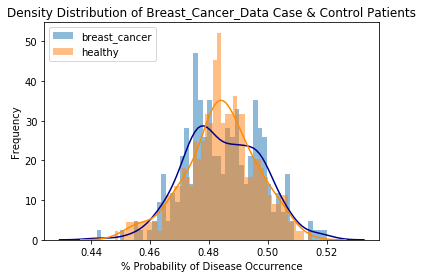

In [2]:
###### NOTE: the X_test still comes from the validation 'training' set we built earlier; separate from pm_test #####

# Splitting into cases where participants either do/do not have disease
X_test_cancer = X_test[y_test == 1,:]             
X_test_healthy = X_test[y_test != 1,:]           

# Calling predict_proba method; % chance of HAVING disease, e.g. chance of feature == 1 
prob_of_healthy_ppl = exported_pipeline.predict_proba(X_test_healthy)    
prob_of_healthy_ppl = prob_of_healthy_ppl[:,1]                

prob_of_cancer_ppl = exported_pipeline.predict_proba(X_test_cancer)
prob_of_cancer_ppl = prob_of_cancer_ppl[:,1]

# Plotting data
plt.hist(prob_of_cancer_ppl, bins = 50, alpha=0.5, label='breast_cancer', density=True)
plt.hist(prob_of_healthy_ppl, bins = 50, alpha=0.5, label='healthy', density=True)

sns.distplot(prob_of_cancer_ppl, hist=False, kde=True, bins=50, color = 'darkblue')
sns.distplot(prob_of_healthy_ppl, hist=False, kde=True, bins=50, color = 'darkorange')

plt.legend(loc='upper left')
plt.xlabel('% Probability of Disease Occurrence')
plt.ylabel('Frequency')
plt.title('Density Distribution of Breast_Cancer_Data Case & Control Patients')
plt.show()



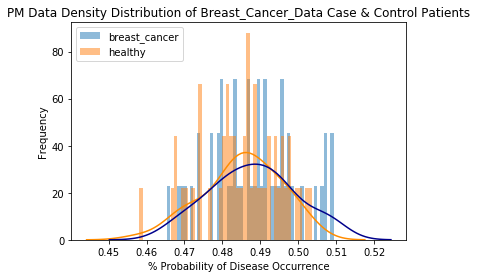

In [3]:
# Load precision medicine dataset; visualize density distribution of healthy & cancer cases

pm_test = pd.read_csv('pm_test.csv')
n_subs = pm_test.shape[0]
n_snps = pm_test.shape[1] - 1

# Splitting into cases where participants either do/do not have disease
X_test_pm_healthy = pm_test.loc[pm_test.phenotype == 0, :].drop('phenotype', axis=1).values 
X_test_pm_cancer = pm_test.loc[pm_test.phenotype != 0, :].drop('phenotype', axis=1).values 

# Calling predict_proba method; % chance of HAVING disease, e.g. chance of feature == 1 
pm_prob_of_healthy_ppl = exported_pipeline.predict_proba(X_test_pm_healthy)   
pm_prob_of_healthy_ppl = pm_prob_of_healthy_ppl[:,1] 

pm_prob_of_cancer_ppl = exported_pipeline.predict_proba(X_test_pm_cancer)
pm_prob_of_cancer_ppl = pm_prob_of_cancer_ppl[:,1]

# Plotting data
plt.hist(pm_prob_of_cancer_ppl, bins = 50, alpha=0.5, label='breast_cancer', density=True)
plt.hist(pm_prob_of_healthy_ppl, bins = 50, alpha=0.5, label='healthy', density=True)

sns.distplot(pm_prob_of_healthy_ppl, hist=False, kde=True, bins=50, color = 'darkorange')
sns.distplot(pm_prob_of_cancer_ppl, hist=False, kde=True, bins=50, color = 'darkblue')

plt.legend(loc='upper left')
plt.xlabel('% Probability of Disease Occurrence')
plt.ylabel('Frequency')
plt.title('PM Data Density Distribution of Breast_Cancer_Data Case & Control Patients')
plt.show()

In [4]:
# Changing each SNP and seeing resulting predict_proba difference in an array of ONE individual

SNP_names = list(pm_test.columns.values)
SNP_names.pop(n_snps)
participant_table = []

for row in range(0, n_subs):
    all_info = []
    val = pm_test.loc[row,:].drop('phenotype').values
    trlarr = val.reshape(1, -1)
    original_prob = exported_pipeline.predict_proba(trlarr)[0,1]

    mylistup = []
    mylistdown = []
    
    for snp in range(0, val.size):
        val[snp] = (val[snp] + 1) % 3
        probup = exported_pipeline.predict_proba(val.reshape(1, -1))[0,1]
        mylistup.append(probup)
        
        val[snp] = (val[snp] - 2) % 3 # -2+1=-1
        probdown = exported_pipeline.predict_proba(val.reshape(1, -1))[0,1]
        mylistdown.append(probdown)
        
        val[snp] = (val[snp] + 1) % 3 # change back
        
    upbumplist = mylistup - original_prob
    downbumplist = mylistdown - original_prob
    uplist = upbumplist.tolist()
    downlist = downbumplist.tolist()
    
    completelist = uplist + downlist + [0] # 0 for no change
    min_index = np.argmin(completelist)
    min_value = min(completelist)
    best_prob = min_value + original_prob
    all_info.append(row + 1) # participant idx
    
    all_info.extend((original_prob, best_prob, original_prob-best_prob))
    if (min_index == (n_snps*2+1)): # no change is best
        all_info.extend(("N/A", "N/A", "N/A"))
    else:
        SNP_idx = min_index % n_snps
        all_info.extend((SNP_names[SNP_idx], int(val[SNP_idx]),
                        int((val[SNP_idx] - 1 + 2*float(min_index <= n_snps)) % 3)))
    
    participant_table.append(all_info)

In [5]:
final_df = pd.DataFrame(participant_table, columns = list([
    'Participant Idx', 'Original Prob.', 'Best Possible Prob.', 'Risk Decrease', 'SNP Name', 'Ori. SNP Value', 'New SNP Value']))

In [6]:
final_df.sort_values(by=['Risk Decrease'], ascending=False).reset_index().drop(['index'], axis=1)


,Participant Idx,Original Prob.,Best Possible Prob.,Risk Decrease,SNP Name,Ori. SNP Value,New SNP Value
0,76,0.507286,0.493829,0.013457,rs1292011,0,2
1,70,0.508755,0.495298,0.013457,rs1292011,0,2
2,35,0.503579,0.490122,0.013457,rs1292011,0,2
3,26,0.502166,0.488709,0.013456,rs1292011,0,2
4,3,0.500650,0.487194,0.013455,rs1292011,0,2
5,39,0.499881,0.486426,0.013455,rs1292011,0,2
6,40,0.497976,0.484523,0.013453,rs1292011,0,2
7,62,0.497429,0.483976,0.013453,rs1292011,0,2
8,18,0.497370,0.483917,0.013453,rs1292011,0,2
9,15,0.496989,0.483536,0.013452,rs1292011,0,2


In [7]:
final_df.to_csv('Optimized_vals.csv', index = False)
# Either we can compute this entire table ex ante, and allow SQL query on the SNP chosen itself.
# Or we can run algorithm every instance of a query
# Runtime variations^